In diesem Notebook wird untersucht, wie sich die F1 Scores in Abhängigkeit vom Overlap Threshold beim labeling der Daten verhalten.

In [2]:
import h5py
from utils.labeling import label_all_files

window_size_sec = 1.0
window_overlap = 0.0
overlap_tresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dir_path = "../../../../tuar_processed"
hdf5_path = "./features/features.hdf5"

for overlap_treshold in overlap_tresholds:
    label_generator = label_all_files(dir_path, window_size_sec, window_overlap, overlap_treshold)

    with h5py.File(hdf5_path, 'a') as hdf5_file:
        for session, label_dict in label_generator:
            session_group = hdf5_file.require_group(session)

            for channel, (data, labels) in label_dict.items():
                channel_group = session_group.require_group(channel)

                if f'labels_{overlap_treshold}_treshold' in channel_group:
                    del channel_group[f'labels_{overlap_treshold}_treshold']

                channel_group.create_dataset(f'labels_{overlap_treshold}_treshold', data=labels, compression="gzip", shuffle=True, chunks=True)

Labeling files in ../../../../tuar_processed: 0it [00:00, ?it/s]
Labeling files in ../../../../tuar_processed/train:   0%|          | 0/320 [00:00<?, ?it/s]

Labeling files in ../../../../tuar_processed/train: 100%|██████████| 320/320 [00:42<00:00,  7.47it/s]
Labeling files in ../../../../tuar_processed/val: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s]
Labeling files in ../../../../tuar_processed/test: 100%|██████████| 118/118 [00:13<00:00,  8.90it/s]
Labeling files in ../../../../tuar_processed: 0it [00:00, ?it/s]
Labeling files in ../../../../tuar_processed/train: 100%|██████████| 320/320 [00:36<00:00,  8.72it/s]
Labeling files in ../../../../tuar_processed/val: 100%|██████████| 98/98 [00:09<00:00, 10.12it/s]
Labeling files in ../../../../tuar_processed/test: 100%|██████████| 118/118 [00:11<00:00, 10.07it/s]
Labeling files in ../../../../tuar_processed: 0it [00:00, ?it/s]
Labeling files in ../../../../tuar_processed/train: 100%|██████████| 320/320 [00:33<00:00,  9.53it/s]
Labeling files in ../../../../tuar_processed/val: 100%|██████████| 98/98 [00:08<00:00, 11.53it/s]
Labeling files in ../../../../tuar_processed/test: 100%|██████████| 

In [13]:
import numpy as np
labels = [f'labels_{threshold:.1f}_treshold' for threshold in np.arange(0, 1.1, 0.1)]
with h5py.File(hdf5_path) as f:
    label_concat = []
    for label in labels:
        label_concat.append(f['aaaaaezj_s007_t002']['FP1-F7'][label][:])

test = np.array(label_concat)
test

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]], shape=(11, 601))

In [14]:
test[:, 100:200]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]], shape=(11, 100))

Das scheint geklappt zu haben. Nun wird mit den optimalen Hyperparametern für jeden Threshold einmal trainiert und dann die F1 Scores visualisiert.

In [15]:
from utils.training import get_features_and_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import joblib


labels = [f'labels_{threshold:.1f}_treshold' for threshold in np.arange(0.0, 1.1, 0.1)]
split_val = 'val'
split_train = 'train'
feature_file = "./features/features.hdf5"
data_split_file = "./data_split.yaml"
features = ['mean', 'variance', 'std', 'ptp_amp', 'kurtosis', 'quantile', 'pow_freq_bands', 'hurst_exp', 'line_length',
            'rms', 'higuchi_fd', 'spect_entropy', 'svd_entropy', 'teager_kaiser_energy', 'wavelet_coef_energy',
            'zero_crossings']

random_state = 42
max_depth = 25
class_weight = 'balanced'

macro_f1_scores = []
inversed_f1_scores = []
regular_f1_scores = []

for label in labels:
    X_train, y_train = get_features_and_labels(feature_file, features, split_train, data_split_file, label)
    X_val, y_val = get_features_and_labels(feature_file, features, split_val, data_split_file, label)
    clf = RandomForestClassifier(n_jobs=-1, class_weight=class_weight, max_depth=max_depth, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    macro_f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    inversed_f1_scores.append(f1_score(y_val, y_pred, pos_label=0))
    regular_f1_scores.append(f1_score(y_val, y_pred))

score_dict = {
    'macro': macro_f1_scores,
    'regular': regular_f1_scores,
    'inversed': inversed_f1_scores
}

joblib.dump(score_dict, 'output/exp_03_09_overlap_f1_scores.joblib')

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:01<00:00, 137.10it/s]
/home/users/jhischke/miniforge3/envs/artifact-detection/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


['output/exp_03_09_overlap_f1_scores.joblib']

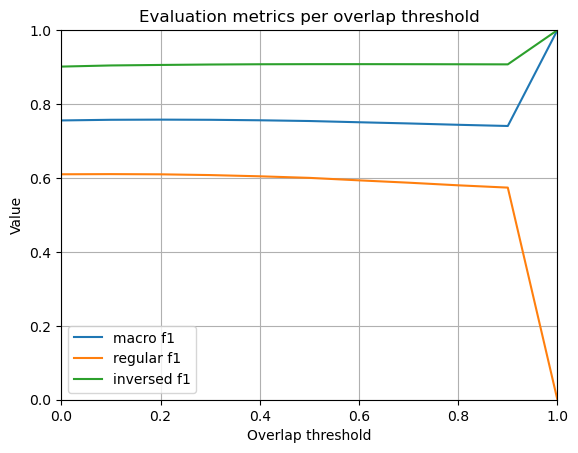

In [16]:
import joblib
from matplotlib import pyplot as plt

scores_dict = joblib.load('output/exp_03_09_overlap_f1_scores.joblib')
overlaps = np.arange(0.0, 1.1, 0.1)

plt.xlabel('Overlap threshold')
plt.ylabel('Value')
plt.title('Evaluation metrics per overlap threshold')
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(overlaps, scores_dict['macro'], label='macro f1')
plt.plot(overlaps, scores_dict['regular'], label='regular f1')
plt.plot(overlaps, scores_dict['inversed'], label='inversed f1')
plt.legend()
plt.savefig('output/exp_03_09_overlap_f1_scores.pdf', bbox_inches='tight')

Im Folgenden wird nun der Anteil Artefaktfenster in den Sets in Abhängigkeit des Overlap Thresholds visualisiert.

In [17]:
import h5py
import numpy as np

labels = [f'labels_{threshold:.1f}_treshold' for threshold in np.arange(0.0, 1.1, 0.1)]
split_val = 'val'
split_train = 'train'
feature_file = './features/features.hdf5'
data_split_file = 'data_split.yaml'

train_set_proportion = []
val_set_proportion = []
total_set_proportion = []


for label in labels:
    _, y_train = get_features_and_labels(feature_file, None, split_train, data_split_file, label_str=label)
    _, y_val = get_features_and_labels(feature_file, None, split_val, data_split_file, label_str=label)

    train_set_true_count = np.sum(y_train)
    train_set_total_count = len(y_train)
    val_set_true_count = np.sum(y_val)
    val_set_total_count = len(y_val)

    train_set_proportion.append(train_set_true_count / train_set_total_count)
    val_set_proportion.append(val_set_true_count / val_set_total_count)
    total_set_proportion.append((train_set_true_count + val_set_true_count) / (train_set_total_count + val_set_total_count))

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:01<00:00, 156.88it/s]


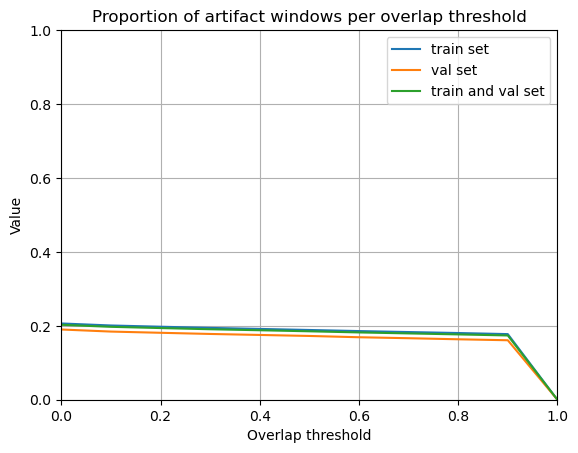

In [18]:
from matplotlib import pyplot as plt

overlaps = np.arange(0.0, 1.1, 0.1)

plt.xlabel('Overlap threshold')
plt.ylabel('Value')
plt.title('Proportion of artifact windows per overlap threshold')
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(overlaps, train_set_proportion, label='train set')
plt.plot(overlaps, val_set_proportion, label='val set')
plt.plot(overlaps, total_set_proportion, label='train and val set')
plt.legend()
plt.savefig('output/exp_03_09_proportion_artifact_windows.pdf', bbox_inches='tight')